### Step 6.  Sentiment Analysis

#### Import submissions and comments from prior steps

In [1]:
import pandas as pd

In [2]:
tfcc_data = pd.read_csv('tfcc_submissions_selected_topics.csv')
tfcc_comments = pd.read_csv('tfcc_comments.csv')


#### Cleanup the comments dataframe by removing the first three characters (this will allow association with the original submission and rename body to selftext)

In [3]:
tfcc_comments = tfcc_comments.rename(columns={'body': 'selftext'})
tfcc_comments['parent_id'] = tfcc_comments['parent_id'].str[3:]

#### Filter comments to only include those which have a parent in the submissions data - this will reduce the total number of comments substantially

In [4]:
# get the number of rows using the shape attribute
start_num_rows = tfcc_comments.shape[0]

# print the number of rows
tfcc_comments = tfcc_comments[tfcc_comments['parent_id'].isin(tfcc_data['id'])]
end_num_rows = tfcc_comments.shape[0]

print("Total rows in comments reduced from " + str(start_num_rows) + " to " + str(end_num_rows))


Total rows in comments reduced from 76848 to 7775


#### Check the sentiment of each row in the submissions dataframe.  Break up the submissions if they are > 512 tokens and then combine the results into a single sentiment score.  Finally, update each row with the sentiment values.  

In [5]:
from transformers import pipeline, DistilBertTokenizerFast
import numpy as np
import torch
from tqdm import tqdm

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")


sentiment_classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    task="sentiment-analysis",
    top_k=None,
    device=0 if torch.cuda.is_available() else -1,  # Set device to GPU if available, otherwise use CPU
)


tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def get_sentiment(row):
    text = row['selftext']
    chunk_size = 512  # number of tokens per chunk
    token_chunks = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        tokens = tokenizer.encode_plus(
            chunk,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=chunk_size,
            return_tensors='pt'
        )
        token_chunks.append(tokens)

    # Analyze sentiment for each chunk
    pos_scores = []
    neg_scores = []
    
    batch_size = 8
    num_batches = len(token_chunks) // batch_size + int(len(token_chunks) % batch_size > 0)

    for batch_idx in tqdm(range(num_batches), desc=f"Processing row {row.name}"):
        batch_start = batch_idx * batch_size
        batch_end = (batch_idx + 1) * batch_size
        batch = token_chunks[batch_start:batch_end]

        input_ids = torch.cat([tokens['input_ids'] for tokens in batch], dim=0).to(device)
        attention_mask = torch.cat([tokens['attention_mask'] for tokens in batch], dim=0).to(device)

        #input_ids = torch.cat([tokens['input_ids'] for tokens in batch], dim=0)
        #attention_mask = torch.cat([tokens['attention_mask'] for tokens in batch], dim=0)

        try:
            with torch.no_grad():
                response = sentiment_classifier.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
            logits = response.logits
            scores = torch.softmax(logits, dim=-1).tolist()
            pos_scores.extend([score[1] for score in scores])
            neg_scores.extend([score[0] for score in scores])
        except Exception as e:
            print(f"Error occurred in row {row.name}: {e}")
            row['pos_sentiment'] = np.nan
            row['neg_sentiment'] = np.nan
            return row

    # Average the sentiment scores
    avg_pos_sentiment = sum(pos_scores) / len(pos_scores)
    avg_neg_sentiment = sum(neg_scores) / len(neg_scores)
    row['pos_sentiment'] = avg_pos_sentiment
    row['neg_sentiment'] = avg_neg_sentiment

    return row


Using GPU


In [6]:
tfcc_data = tfcc_data.apply(get_sentiment, axis=1)


Processing row 3112: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


#### Print the first few rows to confirm the sentiment values have been added

In [7]:
tfcc_data.head()

,id,title,selftext,author,score,num_comments,created_date,selftext_length,topic,pos_sentiment,neg_sentiment
0,zopp4,If you insist... SIR,"well, back at **info line**, we didn't just do...",PoglaTheGrate,25,0,2012-09-11 01:59:24,430,0,0.006426,0.993574
1,ztzum,"OH my goodness, a sub just for me.",so i work at a very large research call center...,[deleted],0,2,2012-09-13 17:57:03,120,6,0.500129,0.499871
2,10hg9t,How to get a pay raise,i work in a call center for assorted online ba...,SWgeek10056,7,15,2012-09-26 01:53:13,260,1,0.282212,0.717788
3,10vp4l,Any stories/rants from chat reps?,i am a chat rep for a major financial firm. i ...,solidsnake78,11,11,2012-10-03 15:58:30,300,10,0.185134,0.814866
4,12blfq,Probably the most uncomfortable hotel room can...,"we get cancellations all the time, it's no big...",SGNick,54,12,2012-10-30 04:13:04,113,14,0.001932,0.998069


#### Export the results to a CSV

In [8]:
tfcc_data.to_csv('tfcc_submissions_with_sentiment.csv', index=False)


#### Perform sentiment analysis on comments

In [9]:
tfcc_comments = tfcc_comments.apply(get_sentiment, axis=1)
tfcc_comments

Processing row 76839: 100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


,parent_id,selftext,score,pos_sentiment,neg_sentiment
27,10hg9t,Look for better paying work. Either you get a ...,1.0,0.517006,0.482995
42,10vp4l,I was one for awhile. \n\nI was a master at co...,4.0,0.002030,0.997970
65,10vp4l,Chat rep here for a university. I always get t...,4.0,0.989766,0.010234
99,12blfq,I work for customer retention for one of the b...,9.0,0.005717,0.994283
116,10vp4l,"All of what you just said, but I have a Number...",4.0,0.001017,0.998983
...,...,...,...,...,...
76806,zz8ztg,The post speaks to me soul. I was in this same...,8.0,0.992200,0.007800
76809,zz8ztg,When I worked in this industry we weren't allo...,10.0,0.451736,0.548264
76812,zz8ztg,Sr. Rep at a call center for medical offices. ...,5.0,0.469292,0.530708
76821,zz8ztg,I posted it elsewhere but I'll say it again:\n...,6.0,0.000496,0.999504


#### Update comments dataframe sentiment column names

In [10]:
tfcc_comments = tfcc_comments.rename(columns={'pos_sentiment': 'comments_pos_sentiment'})
tfcc_comments = tfcc_comments.rename(columns={'neg_sentiment': 'comments_neg_sentiment'})
tfcc_comments

,parent_id,selftext,score,comments_pos_sentiment,comments_neg_sentiment
27,10hg9t,Look for better paying work. Either you get a ...,1.0,0.517006,0.482995
42,10vp4l,I was one for awhile. \n\nI was a master at co...,4.0,0.002030,0.997970
65,10vp4l,Chat rep here for a university. I always get t...,4.0,0.989766,0.010234
99,12blfq,I work for customer retention for one of the b...,9.0,0.005717,0.994283
116,10vp4l,"All of what you just said, but I have a Number...",4.0,0.001017,0.998983
...,...,...,...,...,...
76806,zz8ztg,The post speaks to me soul. I was in this same...,8.0,0.992200,0.007800
76809,zz8ztg,When I worked in this industry we weren't allo...,10.0,0.451736,0.548264
76812,zz8ztg,Sr. Rep at a call center for medical offices. ...,5.0,0.469292,0.530708
76821,zz8ztg,I posted it elsewhere but I'll say it again:\n...,6.0,0.000496,0.999504


#### Export the comments dataframe to a CSV

In [24]:
tfcc_comments.to_csv('tfcc_comments_with_sentiment.csv', index=False)


#### Add a column to the submissions dataframe that shows the average sentiment of comments.  If value is NaN that means the comment was deleted in a prior step because it was too short.

In [12]:
# Calculate the average sentiment for each parent_id in tfcc_comments
sentiment_means = tfcc_comments.groupby('parent_id')[['comments_pos_sentiment', 'comments_neg_sentiment']].mean()


In [13]:
tfcc_data = pd.merge(tfcc_data, sentiment_means, how='left', left_on='id', right_on='parent_id')


In [14]:
tfcc_data

,id,title,selftext,author,score,num_comments,created_date,selftext_length,topic,pos_sentiment,neg_sentiment,comments_pos_sentiment,comments_neg_sentiment
0,zopp4,If you insist... SIR,"well, back at **info line**, we didn't just do...",PoglaTheGrate,25,0,2012-09-11 01:59:24,430,0,0.006426,0.993574,NaN,NaN
1,ztzum,"OH my goodness, a sub just for me.",so i work at a very large research call center...,[deleted],0,2,2012-09-13 17:57:03,120,6,0.500129,0.499871,NaN,NaN
2,10hg9t,How to get a pay raise,i work in a call center for assorted online ba...,SWgeek10056,7,15,2012-09-26 01:53:13,260,1,0.282212,0.717788,0.517006,0.482995
3,10vp4l,Any stories/rants from chat reps?,i am a chat rep for a major financial firm. i ...,solidsnake78,11,11,2012-10-03 15:58:30,300,10,0.185134,0.814866,0.330938,0.669062
4,12blfq,Probably the most uncomfortable hotel room can...,"we get cancellations all the time, it's no big...",SGNick,54,12,2012-10-30 04:13:04,113,14,0.001932,0.998069,0.002362,0.997638
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,zm9qdd,Are you listening to me?,i work for a bank. *a very predatory bank that...,[deleted],294,33,2022-12-15 02:30:58,465,1,0.022500,0.977500,0.783888,0.216112
3109,zpfcr7,Two of my favorite stories...,number 1 - \n\nworked the fraud department for...,_Khalliey_,144,26,2022-12-19 02:24:49,349,1,0.020094,0.979906,NaN,NaN
3110,zwnowo,Why is it so difficult to figure out for custo...,i work for a utility company. i had a call ea...,gameofthrones_addict,57,16,2022-12-27 19:25:20,255,9,0.088221,0.911779,0.002285,0.997715
3111,zxn7bt,Call Totals Giving me Anxiety,does anyone else have to make a certain amount...,BatBitch1016,45,7,2022-12-28 22:31:50,165,12,0.004394,0.995606,0.006136,0.993864


#### Export the updated dataframe to CSV

In [26]:
tfcc_data.to_csv('tfcc_submissions_top20_with_sentiment_including_comment_sentiment.csv', index=False)


#### Retrieve the topics rollup created in prior steps

In [16]:
tfcc_topics = pd.read_csv('tfcc_submissions_topic_counts.csv')


In [17]:
tfcc_topics
tfcc_topics = tfcc_topics.loc[(tfcc_topics['Topic'] != -1) & (tfcc_topics['Topic'] <= 19)]


In [18]:
tfcc_topics

,Topic,Count,Name
1,0,670,0_insurance_patient_clinic_car
2,1,568,1_card_credit_fraud_name
3,2,329,2_bill_plan_data_phones
4,3,202,3_say_help_voice_screaming
5,4,149,4_tow_roadside_truck_assistance
6,5,113,5_delivery_shipping_parcel_orders
7,6,107,6_spanish_language_accent_american
8,7,106,7_software_support_tech_printer
9,8,92,8_cable_box_remote_channel
10,9,87,9_bill_meter_electricity_utility


#### Update the topics rollup to include overall sentiment of the posts and comments associated with each topic

In [19]:
# Group tfcc_data by topic and calculate the mean sentiment scores and comment averages
sentiment_by_topic = tfcc_data.groupby('topic').agg({'pos_sentiment': 'mean', 'neg_sentiment': 'mean', 'comments_pos_sentiment': 'mean', 'comments_neg_sentiment': 'mean'})

# Rename the columns for clarity
sentiment_by_topic = sentiment_by_topic.rename(columns={'pos_sentiment': 'avg_pos_sentiment', 'neg_sentiment': 'avg_neg_sentiment', 'comments_pos_sentiment': 'avg_comments_pos_sentiment', 'comments_neg_sentiment': 'avg_comments_neg_sentiment'})

# Merge the average sentiment scores and comment averages into tfcc_topics by matching on the topic column
tfcc_topics = tfcc_topics.merge(sentiment_by_topic, left_on='Topic', right_index=True)





In [20]:
tfcc_topics.head(20)

,Topic,Count,Name,avg_pos_sentiment,avg_neg_sentiment,avg_comments_pos_sentiment,avg_comments_neg_sentiment
1,0,670,0_insurance_patient_clinic_car,0.120397,0.879603,0.143600,0.856400
2,1,568,1_card_credit_fraud_name,0.120286,0.879714,0.147333,0.852667
3,2,329,2_bill_plan_data_phones,0.124526,0.875474,0.124860,0.875140
4,3,202,3_say_help_voice_screaming,0.135635,0.864365,0.199766,0.800234
5,4,149,4_tow_roadside_truck_assistance,0.156394,0.843606,0.120350,0.879650
6,5,113,5_delivery_shipping_parcel_orders,0.102897,0.897103,0.121552,0.878448
7,6,107,6_spanish_language_accent_american,0.157726,0.842274,0.209272,0.790728
8,7,106,7_software_support_tech_printer,0.118075,0.881925,0.158384,0.841616
9,8,92,8_cable_box_remote_channel,0.106529,0.893471,0.157821,0.842179
10,9,87,9_bill_meter_electricity_utility,0.107128,0.892872,0.163437,0.836563


#### Create a bar chart that shows the relationship between submission and comments sentiment by topic

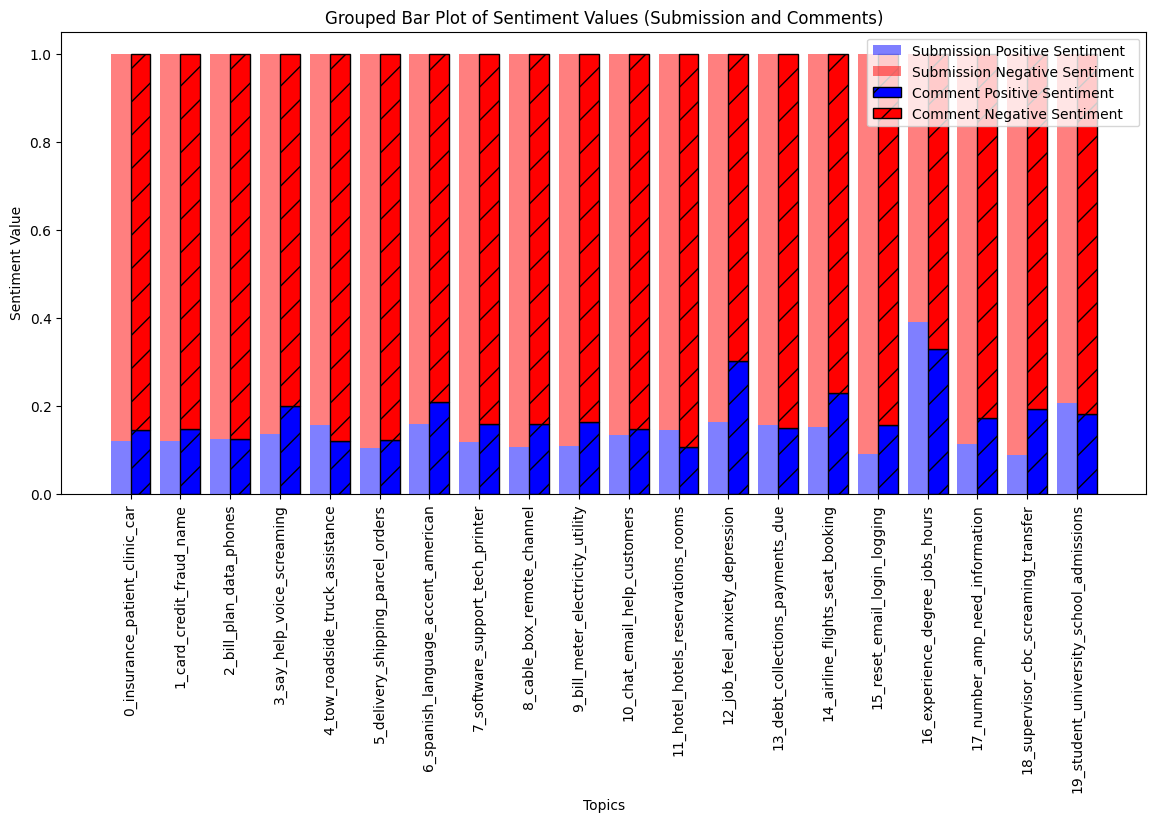

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = tfcc_topics

# Grouped bar plot
n_topics = len(data)
index = np.arange(n_topics)
bar_width = 0.4

plt.figure(figsize=(14, 6))

# Submission sentiments
plt.bar(index, data['avg_pos_sentiment'], bar_width, label='Submission Positive Sentiment', color='blue', alpha=0.5)
plt.bar(index, data['avg_neg_sentiment'], bar_width, label='Submission Negative Sentiment', color='red', alpha=0.5, bottom=data['avg_pos_sentiment'])

# Comment sentiments
plt.bar(index + bar_width, data['avg_comments_pos_sentiment'], bar_width, label='Comment Positive Sentiment', color='blue', hatch='/', edgecolor='black')
plt.bar(index + bar_width, data['avg_comments_neg_sentiment'], bar_width, label='Comment Negative Sentiment', color='red', hatch='/', edgecolor='black', bottom=data['avg_comments_pos_sentiment'])

plt.xticks(index + bar_width / 2, data['Name'], rotation=90)
plt.ylabel('Sentiment Value')
plt.xlabel('Topics')
plt.legend()
plt.title('Grouped Bar Plot of Sentiment Values (Submission and Comments)')
plt.show()

In [25]:
tfcc_topics.to_csv('tfcc_topics_with_sentiment_and_comments_sentiment.csv', index=False)